<a href="https://colab.research.google.com/github/jibz33on/AI-Projects/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis Using LSTM & BiLSTM**

**Overview**

This project implements Sentiment Analysis using Long Short-Term Memory (LSTM) and Bidirectional LSTM (BiLSTM) models to classify movie reviews as either positive or negative. The dataset used is the IMDB Reviews Dataset, and various preprocessing techniques have been applied to improve model accuracy.

**Features**

- Preprocessing: Cleaning text data by removing noise (HTML tags, punctuation, stopwords, etc.).

- Data Exploration: Visualizing sentiment distribution and review lengths.

- Tokenization & Padding: Converting text to numerical sequences for LSTM input.

- Pretrained Embeddings: Utilizing Word2Vec for better word representations.

- LSTM & BiLSTM Models: Training models for sentiment classification.

- Model Evaluation: Analyzing performance with accuracy, loss plots, and validation metrics.

- Prediction : A function for predicting sentiment of new reviews.

**Installation**

To run this project, install the necessary dependencies:

pip install tensorflow pandas numpy nltk scikit-learn matplotlib seaborn

**Dataset**

The dataset is stored in a ZIP file and extracted before use.

- Source: IMDB Reviews Dataset (Kaggle)

- Structure: Two columns (review, sentiment)

- Size: ~50,000 labeled reviews

**Understanding LSTM**
LSTM is a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. Unlike standard RNNs, LSTMs solve the vanishing gradient problem by using gates:

*Forget Gate* - Decides what information to discard.

*Input Gate *- Determines what information to store in the cell state.

*Cell State* - Stores information for long periods.

*Output Gate* - Determines the next hidden state and output.

In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
print("Files in /data/raw/:", os.listdir("/content/drive/My Drive/LSTM_Project/data/raw/"))


Files in /data/raw/: ['IMDB Dataset.csv.zip']


In [4]:
import zipfile # Used to work with zipfiles
import os # Used for handling filepaths and directories
import pandas as pd # Used to work with data in dataframe

def load_csv_from_zip(zip_path, extract_folder="extracted_data"):
   """
   Extracts a ZIP file, finds the first CSV file, and loads it into a Pandas DataFrame.

   Parameters:
   zip_path (str): Full path to the ZIP file.

   Returns:
   pd.DataFrame: Loaded DataFrame from the CSV file.
   """
   # Ensure extraction folder exists
   os.makedirs(extract_folder, exist_ok=True) # Creates a folder if it doesn't exist.

   # Extract the ZIP file
   with zipfile.ZipFile(zip_path, 'r') as zip_ref: # Opens up the zip file in read mode 'r'
       zip_ref.extractall(extract_folder) # Extracts all files into the extract folder

   # List all extracted files
   extracted_files = os.listdir(extract_folder) # Gets all files in the extracted folder
   print("Extracted files:", extracted_files)

   # Find the first CSV file
   csv_files = [f for f in extracted_files if f.endswith(".csv")] # Finds the CSV file
   if not csv_files:
       raise FileNotFoundError("No CSV file found in the ZIP archive.")

   csv_file_path = os.path.join(extract_folder, csv_files[0]) # Combines folder + file to get full CSV path
   print("Using CSV file:", csv_file_path)

   # Load CSV into DataFrame
   df = pd.read_csv(csv_file_path) # Reads CSV into a DataFrame
   print("CSV file loaded successfully.")
   return df

# Define ZIP file path (Ensure filename matches exactly in your Drive)
zip_path = "/content/drive/My Drive/LSTM_Project/data/raw/IMDB Dataset.csv.zip"

# Load CSV into DataFrame
df = load_csv_from_zip(zip_path)

# Display first 5 rows
df.head()


Extracted files: ['IMDB Dataset.csv']
Using CSV file: extracted_data/IMDB Dataset.csv
CSV file loaded successfully.


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Data Preprocessing**

- Convert text to lowercase.

- Remove special characters, punctuation, and HTML tags.

- Convert labels to numerical format (positive → 1, negative → 0).

- Ensure balanced dataset for training.

In [5]:
import re  # Regular expressions (for text cleaning)
import nltk  # Natural Language Toolkit (for text processing)
import pandas as pd  # For working with data in tables
import numpy as np  # For numerical operations
from nltk.corpus import stopwords  # To remove common words (like "the", "is", "and")
#from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split  # To split data into training and testing


In [6]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:


def preprocess_text(text):
    """
    Preprocesses a given text: converts to lowercase, removes special characters,
    punctuation.
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters and punctuation
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single-letter words
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags like <br>
    text = re.sub(r'\bbr\b', ' ', text)  # Remove standalone 'br' (word boundaries)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    #stop_words = set(stopwords.words('english'))  # Get a list of stopwords
    #words = text.split()  # Convert text into a list of words (tokenization)

 # Remove stopwords and apply lemmatization and stemming
    #words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word not in stop_words]  # Remove stopwords, then lemmatize and stem
    #words = [word for word in words if word not in stop_words]  # Remove stopwords
    #return ' '.join(words)  # Convert list of words back into a sentence
    return text


In [13]:
def preprocess_dataframe(df, text_column, label_column):
    """
    Cleans the dataset by:
    - Removing missing values
    - Removing duplicate reviews
    - Preprocessing text (lowercasing, removing punctuation, stopwords)
    - Converting labels to numerical values

    Parameters:
    df (pd.DataFrame): Input dataset.
    text_column (str): Column name containing the text data.
    label_column (str): Column name containing sentiment labels.

    Returns:
    pd.DataFrame: Cleaned dataset (without splitting).
    """

    # Step 1: Check and Remove Missing Values
    missing_before = df.isnull().sum().sum()  # Count total missing values
    df = df.dropna()  # Drop rows with missing values
    missing_after = df.isnull().sum().sum()
    print(f" Missing values removed: {missing_before - missing_after}")

    # Step 2: Check and Remove Duplicates
    duplicates_before = df.duplicated(subset=[text_column]).sum()  # Count duplicate reviews
    df = df.drop_duplicates(subset=[text_column], keep="first")  # Remove duplicates
    duplicates_after = df.duplicated(subset=[text_column]).sum()
    print(f"Duplicate reviews removed: {duplicates_before - duplicates_after}")

    # Step 3: Apply text preprocessing
    df[text_column] = df[text_column].apply(preprocess_text)

    # Step 4: Convert labels ('positive' → 1, 'negative' → 0)
    df[label_column] = df[label_column].map({'positive': 1, 'negative': 0})

    print("Data Preprocessing Completed Successfully!")
    return df  # Returns the fully cleaned dataset (without splitting)


In [15]:
# Define column names
text_column = "review"  # Column containing text data
label_column = "sentiment"  # Column containing sentiment labels

# Preprocess the dataset (cleaning only)
clean_df = preprocess_dataframe(df, text_column, label_column)

# Display first 5 rows of the cleaned dataset
clean_df.head()


 Missing values removed: 0
Duplicate reviews removed: 418
Data Preprocessing Completed Successfully!


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was wonderful way to spend time...,1
3,basically there a family where little boy jake...,0
4,petter mattei love in the time of money is vis...,1


## **Data Visualisation**

<ipython-input-10-057c243c60df>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=clean_df[label_column], palette="coolwarm")


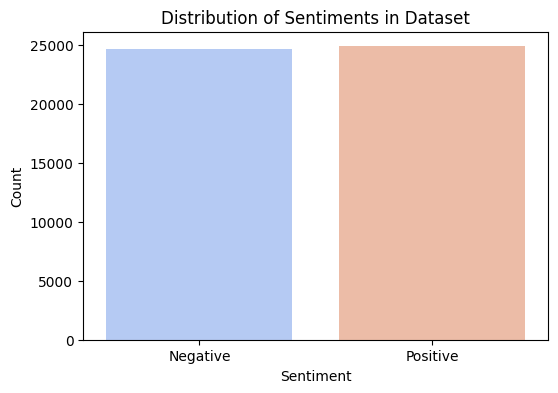

In [10]:
# Sentiment Distribution: Are there more positive or negative reviews?

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=clean_df[label_column], palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiments in Dataset")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.show()

**The key observations**
- Balanced data: Both Positive and negative sentiments are evenly distributed around 250,00
- Since no class imbalance, accuracy is reliable metric for training and F1-score, Precision or Recall is not necessarily needed.
- Randomized train-test split with 80%-10%-10% ratio is appropriate and likely to give a result in a well-trained model. Stratified sampling is more cruical for imbalaanced datase.
- Since the data is balanced the model won't be  biased towards any sentiments.

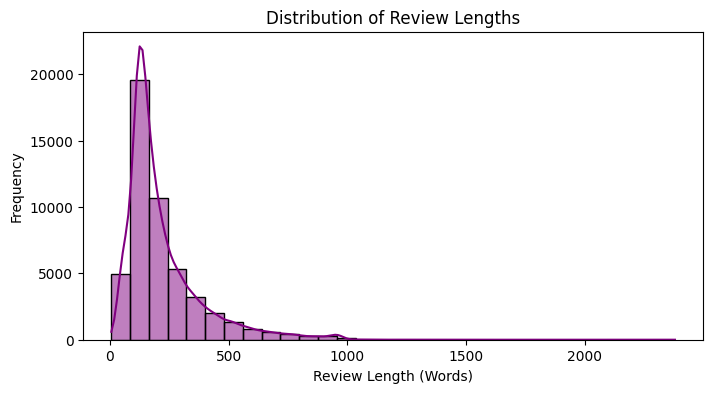

In [11]:
# Review Length: How long are the reviews?
review_lengths = clean_df[text_column].apply(lambda x: len(x.split()))  # Count words in each review

plt.figure(figsize=(8, 4))
sns.histplot(review_lengths, bins=30, kde=True, color='purple')
plt.xlabel("Review Length (Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()


**Key Observations**
- Most reviews are short in 100 - 200 words which means it doesn't require extremely long sequence for training.

- There are some reviews that are extremely long app. 1000 words (outliers). So for ensuring efficiency in training truncated sequence at 200 words.

- Tokenization and padding is needed  at same length (max_length= 200)

- Truncating strategy: Cut off extra words beyond 200 (truncating='post')

- LSTM Model Considerations :
 Use moderate LSTM units (128-64) to balance accuracy & efficiency.
Add Dropout (0.2-0.3) to prevent overfitting.
Use Pretrained Word Embeddings (GloVe) for better word representation.

-Training Considerations :
Batch Size = 64 (for stable training).
Epochs = 10-15 (monitor validation loss).
Early Stopping (stops training if model overfits).

<ipython-input-12-952a6574d199>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Word", data=common_words_positive, palette="viridis")


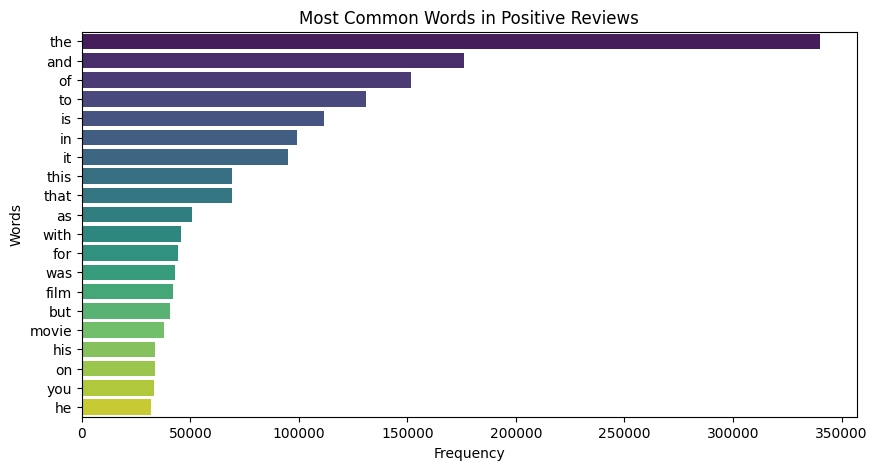

In [12]:
# Most common words in Positive reviews

from collections import Counter
import itertools
import pandas as pd

# Extract words from positive reviews
positive_reviews = clean_df[clean_df[label_column] == 1][text_column]
all_words_positive = list(itertools.chain(*[text.split() for text in positive_reviews]))

# Get most common words
word_counts_positive = Counter(all_words_positive)
common_words_positive = pd.DataFrame(word_counts_positive.most_common(20), columns=["Word", "Count"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Word", data=common_words_positive, palette="viridis")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Most Common Words in Positive Reviews")
plt.show()


**Key Observations **

- 'br' Has Been Successfully Removed → Preprocessing is working correctly.

- Film-Related Words Dominate → Words like "film", "movie", "story", "great", "best", "love" suggest the dataset is movie review-focused.

- Common Neutral Words Still Exist → Words like "one", "time", "well", "also", "really" don’t add strong sentiment value and might be filtered.

- Limit Vocabulary Size → Set num_words=10,000 to keep only relevant words and remove rare ones.

- Use Pretrained Embeddings (Word2Vec) → This will help the model understand sentiment context better.

- Optimize Training by Reducing Noise → Remove unnecessary words, add dropout layers, and monitor validation loss.

<ipython-input-13-35599f8ca119>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Word", data=common_words_negative, palette="coolwarm")


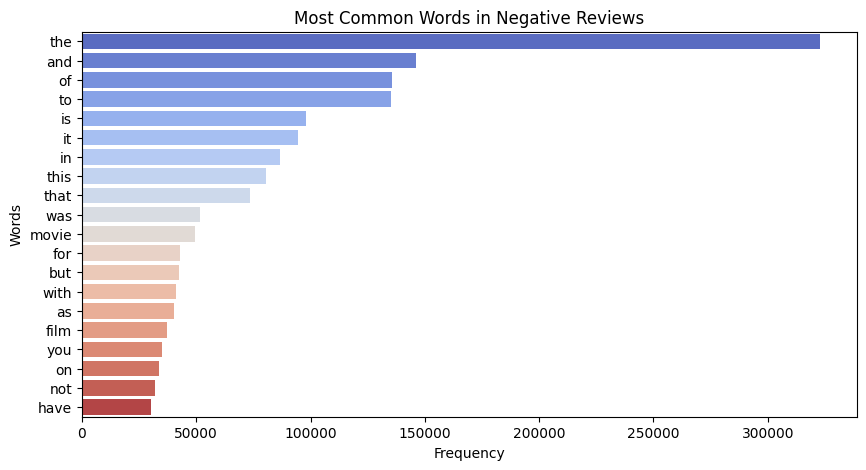

In [13]:
# Most common words in Negative reviews

# Extract words from negative reviews
negative_reviews = clean_df[clean_df[label_column] == 0][text_column]
all_words_negative = list(itertools.chain(*[text.split() for text in negative_reviews]))

# Get most common words
word_counts_negative = Counter(all_words_negative)
common_words_negative = pd.DataFrame(word_counts_negative.most_common(20), columns=["Word", "Count"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Word", data=common_words_negative, palette="coolwarm")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Most Common Words in Negative Reviews")
plt.show()


Summary of Important Things

- Film-Related Words Dominate → The dataset is movie-review focused, so sentiment-heavy words are mixed with general movie-related terms.

- Weak Sentiment Words Appear Frequently → Neutral words like "one", "time", "even", "would", "get" don’t contribute much to sentiment detection. Manually filter them out to improve model focus.

- Negative Sentiment Words Are Less Frequent → Unlike positive reviews, negative reviews don’t have strong sentiment words (only "bad" stands out). This might make the model struggle.

- Refine Preprocessing → Remove unnecessary words, but keep sentiment-heavy words to improve classification accuracy.

- LSTM Model Should Include Attention Layers → Helps focus on important words, especially for weakly expressed negative sentiments.

- Use Dropout (0.3) & Monitor Validation Loss → Prevent overfitting & ensure the model generalizes well.

**Splitting the data**

- We use 80%-10%-10% ratio for splitting the data here

80% Training Data → The LSTM model learns patterns from a large portion of the dataset.

10% Validation Data → Helps fine-tune hyperparameters (e.g., LSTM units, dropout) & prevent overfitting.

10% Test Data → Ensures the model generalizes well on unseen data and provides a reliable accuracy score.



In [17]:
from sklearn.model_selection import train_test_split

def split_data(texts, labels):
    """
    Splits dataset into train, validation, and test sets using an 80-10-10 ratio.

    Parameters:
    texts (list): List of cleaned text data.
    labels (list): Corresponding sentiment labels.
    test_size (float): Proportion of data to hold out for test+validation.
    val_size (float): Proportion of remaining test set used for validation.
    random_state (int): Seed for reproducibility.

    Returns:
    train_texts, val_texts, test_texts, train_labels, val_labels, test_labels
    """
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=0.1, random_state=42, stratify=labels


    )

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=0.1, random_state=42, stratify=train_labels
    )



    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels

# Example Usage
train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = split_data(
    clean_df[text_column], clean_df[label_column]
)


**Tokenization and Padding.**

Tokenization and padding is the final step of data preprocessing before feeding into the LSTM model .

*Why Are We Using Tokenization & Padding?

LSTM models cannot process raw text data directly, so we need to convert text into numerical sequences before feeding it into the model.

🔹 Tokenization → Converts words into unique integer IDs (numerical format).

🔹 Padding → Ensures all sequences have the same length for LSTM processing.

Without tokenization & padding, the model cannot understand words or handle varying review lengths.

Things that we are going to use

*   Set max_length=200 (truncate long reviews, pad short ones).
*   Limit vocabulary to 10,000 words (num_words=10000) to avoid unnecessary tokens.
*  Use Tokenizer(num_words=10000, oov_token="<OOV>") → Limits vocabulary to most frequent words.
*  Use pad_sequences(maxlen=200, padding='post', truncating='post') → Ensures all sequences are of fixed length.
*  Tokenize & pad separately for train_texts, val_texts, and test_texts → To prevent data leakage.



In [19]:
pip install tensorflow

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [21]:
def tokenize_and_pad(texts, vocab_size=10000, max_length=150):
    """
    Tokenizes text data and applies padding.

    Parameters:
    texts (list): List of text reviews.
    vocab_size (int): Maximum number of words in vocabulary.
    max_length (int): Fixed sequence length.

    Returns:
    sequences (array): Tokenized & padded sequences.
    tokenizer (object): Fitted tokenizer for inverse mapping.
    """
    print("Type of input received:", type(texts))
    print("Example of first 5 inputs:", texts[:5])  # Check first 5 elements

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')  # OOV token for unseen words
    tokenizer.fit_on_texts(texts)  # Learn word mappings

    sequences = tokenizer.texts_to_sequences(texts)  # Convert words to integers
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')  # Pad sequences

    return padded_sequences, tokenizer


In [22]:
# Apply tokenization & padding separately for each dataset split
padded_train, tokenizer = tokenize_and_pad(train_texts) # Calls the tokenize_and_pad function
padded_val, _ = tokenize_and_pad(val_texts, vocab_size=10000, max_length=250) # Does the same tokenization and padding for validation data with mentioned specifies.
                                                                              # Stores in padded_val, underscore _ is a placeholder for the tokenized and padded validation data.
padded_test, _ = tokenize_and_pad(test_texts, vocab_size=10000, max_length=250)


Type of input received: <class 'pandas.core.series.Series'>
Example of first 5 inputs: 4674     though it hardly compares to other sci fi film...
35895    if jacqueline mckenzie and john lynch weren su...
33299    i ve just visited russian forum of our tv chan...
36935    hmmm yeah this episode is extremely underrated...
31773    i seem to be disagreeing with lot of folks her...
Name: review, dtype: object
Type of input received: <class 'pandas.core.series.Series'>
Example of first 5 inputs: 44812    i went to this movie expecting an artsy scary ...
20176    fado is sad almost bluesy style of portuguese ...
797      emma is horribly flawed film based on jane aus...
22837    cause they re both pretty lousy think the best...
16012    movies just don get worse than this horrible p...
Name: review, dtype: object
Type of input received: <class 'pandas.core.series.Series'>
Example of first 5 inputs: 28895    _saltmen_ is long film for its genre and quite...
25362    in iran women are not adm

In [23]:
print(tokenizer.word_index['<OOV>'])  # Check frequency of OOV tokens


1


In [24]:
print("Training Data Shape:", padded_train.shape)
print("Validation Data Shape:", padded_val.shape)
print("Test Data Shape:", padded_test.shape)


Training Data Shape: (40160, 150)
Validation Data Shape: (4463, 250)
Test Data Shape: (4959, 250)


In [25]:


print("Positive labels in Train:", np.sum(train_labels))
print("Negative labels in Train:", len(train_labels) - np.sum(train_labels))


Positive labels in Train: 20155
Negative labels in Train: 20005


# **Model Development**

**Why LSTM/BiLSTM?**

LSTMs are effective for sequential data because they can learn long-term dependencies better than regular RNNs. BiLSTM improves accuracy by capturing context from both directions (past & future words).

**Model Architecture**

- Embedding Layer: Uses pretrained Word2Vec embeddings.

- Bidirectional LSTM (BiLSTM): Captures sequence dependencies.

- Dropout Layers: Prevents overfitting.

- Dense Layer: Outputs sentiment classification (0 or 1).

- Activation Function: sigmoid for binary classification.

- Loss Function: binary_crossentropy (used for binary classification tasks).

- Optimizer: Adam (adaptive learning rate optimizer).

In [21]:
# Download GloVe Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-03-02 14:21:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-02 14:21:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-02 14:21:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [64]:
# Load GloVe Embeddings

#import numpy as np

# Load GloVe embeddings (50D, 100D, or 300D)
#glove_path = "/content/glove.6B.100d.txt"  # Path to downloaded GloVe file

# Load the embeddings into a dictionary
#embedding_index = {}

#with open(glove_path, encoding='utf-8') as f:
   # for line in f:
    #    values = line.split()
    #    word = values[0]  # First value is the word
    #    coeffs = np.asarray(values[1:], dtype='float32')  # Remaining values are the embedding vector
     #   embedding_index[word] = coeffs

#print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [65]:
# Create an Embedding Matrix
#embedding_dim = 100  # Use 100D GloVe vectors
#word_index = tokenizer.word_index  # Get word-index mapping from tokenizer

# Initialize embedding matrix (vocab_size, embedding_dim)
#embedding_matrix = np.zeros((10000, embedding_dim))

#for word, i in word_index.items():
    #if i < 10000:  # Limit to vocab size
      #  embedding_vector = embedding_index.get(word)  # Get GloVe vector if word exists
       # if embedding_vector is not None:
         #   embedding_matrix[i] = embedding_vector  # Assign GloVe vector to word index

#print("✅ Embedding matrix created!")


✅ Embedding matrix created!


In [26]:
from gensim.models import Word2Vec  # CHANGE MADE: Using Word2Vec Instead of GloVe

# Train Word2Vec on IMDB dataset (self-trained embeddings)
train_sentences = [text.split() for text in train_texts]
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=5, workers=4)


In [27]:
# Create an Embedding Matrix for Word2Vec
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((10000, embedding_dim))

for word, i in word_index.items():
    if i < 10000 and word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

print("Word2Vec Embedding Matrix Created!")


Word2Vec Embedding Matrix Created!


In [28]:
# Define the model architecture

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Define Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=150,
              weights=[embedding_matrix], trainable=True),  # Use Pretrained GloVe
    SpatialDropout1D(0.2),
    #LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)),  # Reduce LSTM units & add L2 regularization,
    Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.005))),  # Bidirectional LSTM
    Dropout(0.3),
    #LSTM(32, kernel_regularizer=l2(0.01)),  # Reduce second LSTM layer size
    #Bidirectional(LSTM(32)),  # Second Bidirectional LSTM layer
    LSTM(32, kernel_regularizer=l2(0.005)),
    #Bidirectional(LSTM(16, kernel_regularizer=l2(0.01))),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
# Compile the model

from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])



In [30]:
# Display the Model Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

**Training Strategy**

- Train-Validation-Test Split: 80%-10%-10%

- Batch Size: 64

- Epochs: 15 (early stopping applied)

- Optimizer: Adam (learning rate 0.0001)

- Evaluation Metrics: Accuracy, loss, and validation loss monitoring.

In [31]:
# Define training parameters

batch_size = 64  # Number of samples per training step
epochs = 15  # Number of training iterations

In [32]:
# Tain the Model

from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Retrain the Model
history = model.fit(
    padded_train, train_labels,
    validation_data=(padded_val, val_labels),
    batch_size=batch_size,
    epochs=epochs,  # Can run longer, but early stopping will stop unnecessary epochs
    callbacks=[early_stop],  # Stop if no improvement in 5 epochs
    verbose=1
)




Epoch 1/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5381 - loss: 1.9397 - val_accuracy: 0.5649 - val_loss: 1.3595
Epoch 2/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.7367 - loss: 1.1195 - val_accuracy: 0.5649 - val_loss: 1.2290
Epoch 3/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.7730 - loss: 0.9215 - val_accuracy: 0.5521 - val_loss: 1.2015
Epoch 4/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7846 - loss: 0.8224 - val_accuracy: 0.5521 - val_loss: 1.1480
Epoch 5/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8012 - loss: 0.7367 - val_accuracy: 0.5581 - val_loss: 1.1972
Epoch 6/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8127 - loss: 0.6761 - val_accuracy: 0.5532 - val_loss: 1.1020
Epoch 7/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8266 - loss: 0.6211 - val_accuracy: 0.5691 - val_loss: 1.0621
Epoch 8/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8280 - loss: 0.5950 - 

**Model Evaluation**

- Test Accuracy: Displayed after model evaluation.

- Plots: Training & validation loss/accuracy plots.

- Confusion Matrix: Analyze misclassifications.

In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(padded_test, test_labels)

# Print test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5589 - loss: 1.0672
Test Accuracy: 0.5531
Test Loss: 1.0826


In [34]:
# Monitoring the training progress



# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()


NameError: name 'plt' is not defined

**Predictions**

In [35]:
def preprocess_new_text(text):
    """
    Preprocess a new review to match the format used during training.
    """
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\bbr\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [36]:
def predict_sentiment(review_text):
    """
    Preprocesses, tokenizes, and predicts the sentiment of a new review.
    """
    # Step 1: Preprocess the new text
    processed_text = preprocess_new_text(review_text)

    # Step 2: Convert to sequence using trained tokenizer
    sequence = tokenizer.texts_to_sequences([processed_text])

    # Step 3: Pad sequence to match model's input shape
    padded_sequence = pad_sequences(sequence, maxlen=300, padding='post', truncating='post')

    # Step 4: Make prediction
    prediction = model.predict(padded_sequence)

    # Step 5: Convert probability to sentiment label
    sentiment = "Positive 😀" if prediction[0][0] > 0.5 else "Negative 😠"

    # Step 6: Print result
    print(f"🔹 Review: {review_text}")
    print(f"🔹 Sentiment: {sentiment} (Confidence: {prediction[0][0]:.4f})")

# Example Usage: Test the model with a new review
new_review = "This movie was absolutely fantastic! The story was gripping and the acting was top-notch."
predict_sentiment(new_review)

new_review2 = "I hated this movie. The plot was terrible and the acting was so bad it was painful to watch."
predict_sentiment(new_review2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
🔹 Review: This movie was absolutely fantastic! The story was gripping and the acting was top-notch.
🔹 Sentiment: Positive 😀 (Confidence: 0.9252)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
🔹 Review: I hated this movie. The plot was terrible and the acting was so bad it was painful to watch.
🔹 Sentiment: Negative 😠 (Confidence: 0.0713)


**Possible Improvements**

- Add attention mechanisms for better focus on key words.

- Experiment with transformer-based models (BERT, DistilBERT).

- Fine-tune hyperparameters for improved performance.